## <font color='red'>DISCLAIMER: If you want to run our system with your own input, we have mentioned in RED, the cells you need to run. Thank you! </font>

# Introduction:
With the growing risk of fast pace spread of COVID-19 across the globe, there is an extreme need for potential way forward or approaches to break the chain if not cure. Currently, there is significant research & literature around the similar situation during previous epidemics spread which may not be specific for current situation but still very valuable. This might provide us with right approaches and improved policy measures which will aid us to fight this battle. We, as AI & NLP researchers, hope to leverage this research, ideas, reports or any data to find close to accurate and quickly actionable insights to control the spread via medical or non-Pharma interventions.

With this, we hope to bring in our approach / engine which can help community members to find right literature using the methods of NLP, Deep Learning & Search. The approach mainly uses Facebook AI Similarity Search (FAISS) for indexing documents and Google's Universal Sentence Encoder for the text embeddings.

The approach was designed keeping in mind the task of finding the right insights for “What do we know about non-pharmaceutical interventions?” but we expanded its reach to solve sub-questions or any relevant questions from all 10 tasks specified in CORD-19 Challenge by Kaggle community.

# Team members:
We, the Text Analytics team, are pleased to provide to the Kaggle community, an Information Retrieval system using NLP, Machine Learning and Deep Learning techniques.  

[Bharat Hegde], [Rohit Rangarajan], [Prathamesh Karmalkar], [Harsha Gurulingappa], [Gerard Megaro]

# Problem statement:
We started with the goal of solving the task "What do we know about non-pharmaceutical interventions?", but ended up developing a solution which would work across all given tasks and questions.

# Our approach:
* We extract docs from the dataset using NLTK, Theme Extractor (proprietary algorithm to be published in September 2020) and JSON parser. Each doc is a json object of the form:
        {
            'sentence': '....',
            'section': '....',
            'paper_title': '....',
            'authors': [],
            'paragraph': '....',
            'themes': []
        }
* The themes are identified from the abstract of the paper in which the sentence appears.        

* Once all docs are extracted, we obtain the sentence embeddings for all sentences extracted from each of these docs, using Google’s Universal Sentence Encoder. 

* We then index all the embeddings into one of the available FAISS indexes, called the ScalarQuantizer (https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization).  

* Then, when user makes a query, we convert the query to its text embedding using the same Universal Sentence Encoder and query our index. 

* The index returns the id of the embeddings (along with L2 distance) which are most similar to the query embedding. We then map those ids to the corresponding doc objects to display the details to the user.

* We also provide additional information, such as the paragraph context in which the sentence appears, the paper containing the sentence, the authors of the paper, title of that paper, and section name. Therefore the  user can look into the paper for more detais regarding the query.

* We also provide a ThemeCloud which gives a pictorial representation of the themes being talked about in the paper.  

# Our approach:

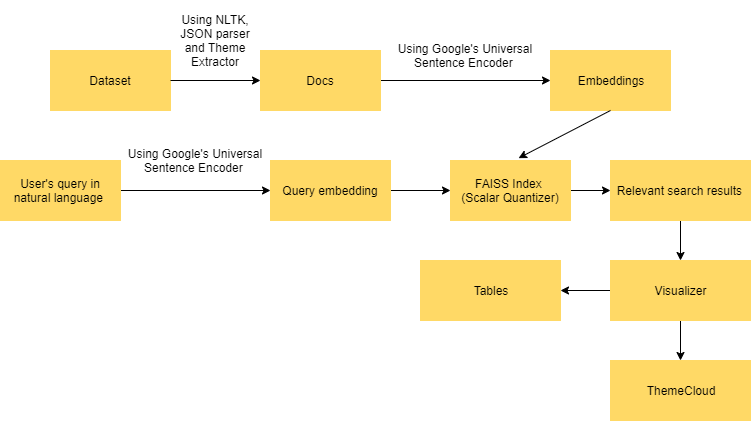

# Indexing stage

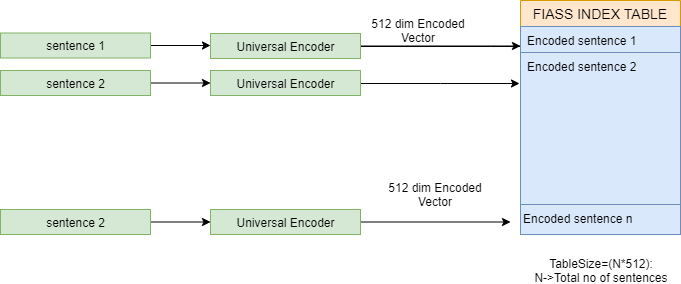

# Querying stage

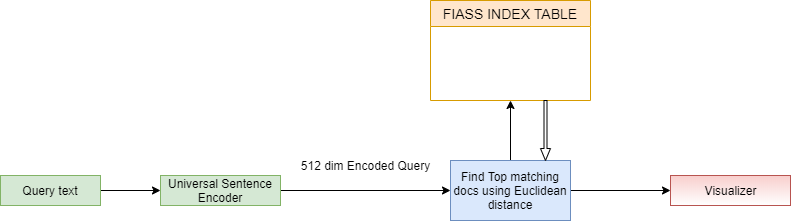

## Dataset: 

33375 papers across 4 folders: 

* biorxiv_medrxiv - 1053 papers

* comm_use_subset - 9315 papers

* custom_license - 20657 papers

* noncom_use_subset - 2350 papers


# Algorithm for theme extraction:
Theme extraction helps to define the context and content of a conversation providing a highly valuable combination of contextual phrases. Phrase themes provide an excellent view of the context of conversation and is useful on all content length from one line to hundred-page document. Theme identification is one of the most fundamental tasks in qualitative research. System takes unstructured data as input and extracts semantic themes based on context of the data.

Step 1: Pre-process the input verbatim for identifying the themes

Step 2: Identify & split verbatim into multiple sentences to identify individual themes at sentence level (Themes specific to each question)

Step 3: Algorithm extracts the themes using tokenization, PoS tags, chunks, dependency parse tree as features of the input verbatim.

Step 4: Extract first set of themes from input verbatim

Step 5: Algorithm uses heuristic approach to prune contextually less significant chains from the extracted theme set

## The code below makes use of our internal tool for extracting themes from text. This will not work in external networks. It has been provided only for documentation purposes.

In [ ]:
import requests
import json

headers = {'accept': 'application/json','Content-Type': 'text/plain'}
params = (('annotationTypes', '*'),('language', 'en'))

def get_json_object(text):
    return requests.post('<our url>', headers=headers, params=params, data=text).json()

# Output: json string
def get_json_str(json_obj):
    return json.dumps(json_obj)

# Output: beautified json string
def get_pretty_json(json_str):
    return json.dumps(json_str, indent=4)

# Output: List of themes
def get_themes(text):
    json_obj = get_json_object(text)
    json_array = json_obj["annotationDtos"]
    return json_array[-1]["themes"]

# Download Google Universal Sentence Encoder for extracting sentence embedding from text

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Define function to join words in a list into one string
### This method is useful when extracting author names from the provided json files

In [ ]:
def lst_to_str(word_list):
    return ' '.join(word_list).strip()

# Collect sentences as python list
#### In the below code, we make use of NLTK's sentence tokenizer to extract sentences out of paragraphs. We also tried spaCy's tokenizer, but found this to be faster.

In [ ]:
import numpy as np
import json
import os
import csv
import time
from nltk.tokenize import sent_tokenize

root = '/kaggle/input/dataset/CORD-19-research-challenge/'
folders = ['biorxiv_medrxiv/biorxiv_medrxiv/', 'comm_use_subset/comm_use_subset/', 
           'noncomm_use_subset/noncomm_use_subset/', 'custom_license/custom_license/']


def collect_sentences():
    index_in_docs = 0
    num_files_processed = 0
    sentences_np_array = np.empty(100000000, dtype=object)

    start = time.time()
    for folder in folders:
        for filename in os.listdir(root+folder):
            if filename.endswith(".json"): 
                input_file_path = root+folder+filename
                with open(input_file_path) as f:
                    data = json.load(f)

                    # Collect abstract sentences
                    abstracts = data['abstract']
                    for content in abstracts:
                        abstract_para = content['text']
                        sentences = sent_tokenize(abstract_para)
                        for sentence in sentences:
                            sentences_np_array[index_in_docs] = sentence
                            index_in_docs += 1

                    # Collect body sentences
                    body_texts = data['body_text']
                    for content in body_texts:
                        body_para = content['text']
                        sentences = sent_tokenize(body_para)
                        for sentence in sentences:
                            sentences_np_array[index_in_docs] = sentence
                            index_in_docs += 1
                num_files_processed += 1            
                print('Num files processed: ' + str(num_files_processed))
                print('Time taken since beginning = ' + str(time.time()-start))
    np.save('sentences.npy', sentences_np_array) 

# Collect json docs
#### The lines calling the get_themes() method have been commented since the method will only work in our internal environment

In [ ]:
import json
import os
import csv
import time
from nltk.tokenize import sent_tokenize

root = '/kaggle/input/dataset/CORD-19-research-challenge/'
folders = ['biorxiv_medrxiv/biorxiv_medrxiv/', 'comm_use_subset/comm_use_subset/', 
           'noncomm_use_subset/noncomm_use_subset/', 'custom_license/custom_license/']

def collect_json_docs():
    docs = np.empty(100000000, dtype=np.object) 

    index_in_docs = 0
    num_files_processed = 0
    num_docs_collected = 0

    start = time.time()
    for folder in folders:
        for filename in os.listdir(root+folder):
            if filename.endswith(".json"): 
                input_file_path = root+folder+filename
                print(input_file_path)
                with open(input_file_path) as f:
                    data = json.load(f)

                    # Collect paper title
                    paper_title = data['metadata']['title']

                    # Collect authors' names
                    authors = data['metadata']['authors']
                    authors_names = []

                    for author in authors:
                        first_name = author['first']
                        middle_name = author['middle']
                        last_name = author['last']
                        author_name = first_name + ' ' + lst_to_str(middle_name) + ' ' + last_name
                        authors_names.append(author_name)

                    # Collect abstract sentences
                    abstracts = data['abstract']
                    for content in abstracts:
                        abstract_para = content['text']
                        section = content['section']
                        sentences = sent_tokenize(abstract_para)
    #                     para_themes = get_themes(abstract_para)
                        for sentence in sentences:
                            new_doc = {
                                "sentence": sentence,
                                "section": section,
                                "paper_title": paper_title,
                                "authors": authors_names,
                                "paragraph": abstract_para
    #                             "para_themes": para_themes
                            }
                            print(new_doc)
                            docs[index_in_docs] = new_doc
                            index_in_docs += 1
                            num_docs_collected += 1

                    # Collect body sentences
                    body_texts = data['body_text']
                    for content in body_texts:
                        body_para = content['text']
                        section = content['section']
                        sentences = sent_tokenize(body_para)
    #                     para_themes = get_themes(body_para)
                        for sentence in sentences:
                            new_doc = {
                                "sentence": sentence,
                                "section": section,
                                "paper_title": paper_title,
                                "authors": authors_names,
                                "paragraph": body_para
    #                             "para_themes": para_themes
                            }
                            print(new_doc)
                            docs[index_in_docs] = new_doc
                            index_in_docs += 1
                            num_docs_collected += 1
                num_files_processed += 1

    np.save('docs', docs) # by default, allow pickle = True

# Load docs.npy
### docs.npy file contains json objects - each json object contains the section_name, author names, paper title, sentence, themes, and paragraph in which the sentence occurs.

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
import numpy as np
docs = np.load('/kaggle/input/jsondocs/docs.npy', allow_pickle=True)

# Why Google's Universal Sentence Encoder?

    We tried Sentence Transformer for the embeddings, it had 768 dimension representation and 
    thus it occupied more size (768 * ~ 7 million sentences = 18 GB approx). Also, time taken 
    to generate the embeddings for 7 million sentences was around 3.5 hours with K80 GPU on AWS Sagemaker.
    You can refer to Sentence Tranformer here: https://github.com/UKPLab/sentence-transformers
    
    But in case of Google Universal Sentence Encoder, it has 512 dimensional vector embedding 
    for each sentence, thereby occupying less space (512 * ~ 7 million sentences = 12 GB approx), 
    but equally effective as Sentence Transformer. Time complexity is O(n)(n is length of sentence).
    Embeddings were computed on Sagemaker, with configuration 8 virtual CPUs, one V100 GPU of 
    16 GB memory, and 61 GB RAM. This took around 20 minutes to compute all embeddings - way faster. 
    It took 1325 seconds to compute 7191466 embeddings.    

# Extract embeddings from the 'sentence' field of docs collected above - using Google Universal Sentence Encoder - and save them!


### Extract the sentences from docs loaded above

In [ ]:
def collect_sentences():
    sentences=[]
    for jsonobject in docs:
        sentences.append(jsonobject['sentence'])

### Generate embeddings for sentences collected above. We ran the below code in AWS Sagemaker because of RAM issue in Kaggle (resource exhausted error). Total size of embeddings.npy was around 12 GB. It is removed from notebook because of lack of space.

In [ ]:
import tensorflow as tf
import time

 
def generate_embeddings():
    start = time.time()
    index=0
    batch_size = 3000
    num_rows=len(sentences)


    embeddings = np.empty((num_rows,512), dtype=np.float32)
    while index < num_rows:
        end_index = index+batch_size
        if end_index > num_rows:
            break
        embeddings[index:end_index,:] = embed(sentences[index:end_index])
        index += batch_size

    if index < num_rows:
        embeddings[index:num_rows,:] = embed(sentences[index:num_rows])

    np.save('embeddings/embeddings.npy', embeddings) # removed from working directory

# Why FAISS for indexing the embeddings?
Faiss is a library developed by Facebook AI Research, for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. Faiss provides lightning fast search through 1 billion vectors.

Total size of the index after indexing the embeddings was around 12 GB. Faiss provides a Scalar Quantization technique using which we were able to reduce the size to around 3 GB (32 bit float to 6 bit representation).

We used L2 euclidean distance provided by FAISS, for computing distance between embeddings. Since we are computing similarity using L2 distance, loss of accuracy due to quantization does not affect query results. 


Search operation in our case is linear and time complexity is O(n)(n is total number of embeddings indexed).

# Install FAISS to use GPU

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
!python -m pip install --upgrade faiss faiss-gpu

# Load embeddings from npy file and index the embeddings into FAISS, and save the index in correct directory. 
### Please note: 'embeddings.npy' file is not available in notebook - so this cell will throw an error. 
### Index was created in AWS Sagemaker and uploaded in data directory in /kaggle/input/vector/vector_6.index


In [ ]:
import numpy as np
import faiss

def create_index():
    embeddings = np.load('embeddings/embeddings.npy',mmap_mode='r')
    index = faiss.IndexScalarQuantizer(512,faiss.ScalarQuantizer.QT_6bit) 
    index.train(embeddings)
    index.add(embeddings)

    faiss.write_index(index, "vector_6.index")

# Search docs matching user query

## Load index from directory where it was saved. Index can be saved and loaded from disk.

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
import faiss
index = faiss.read_index("/kaggle/input/vector/vector_6.index", faiss.IO_FLAG_MMAP|faiss.IO_FLAG_READ_ONLY)  # load the index

## Search the index

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
import time
query = ["What has been published concerning research and development and evaluation efforts of vaccines and therapeutics for COVID-19?"]
query_vector = embed(query)
query_vector = np.asarray(query_vector, dtype=np.float32)

start = time.time()
D, I = index.search(query_vector, 10)  

# Visualize the results!

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
!pip install json2html
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
from json2html import *
from IPython.core.display import display, HTML

## <font color='red'>RUN BELOW CELL! ---> </font>

In [ ]:
stopwords = set(STOPWORDS)

for id_index in I[0]:
    doc = docs[id_index]
    html = json2html.convert(doc)
    html = html.replace("<td>", "<td style='text-align:left'>")
    display(HTML(html))
    themes_list = doc['themes']
    final_theme_string = ''
    for theme in themes_list:
        words = theme.replace('-', ' ').split()
        t = '_'.join(words)
        final_theme_string = final_theme_string + ' ' + t
        
    # plot the WordCloud image  
    if doc['themes'] and doc['themes'][0]:
        wordcloud = WordCloud(width = 700,height = 200,stopwords = stopwords,min_font_size = 8, 
                              max_font_size=20, background_color='white', 
                              prefer_horizontal=1).generate(final_theme_string)
        plt.figure(figsize = (10, 10), linewidth=10, edgecolor="#04253a")
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.show() 
    display(HTML("<hr style='height:3px; color:black'>"))

# Write to excel sheet

In [ ]:
import pandas as pd
writer = pd.ExcelWriter('QueryResult1.xlsx', engine='xlsxwriter')

def writepaperdetails(query,retrivallines,subquestion):
    print(subquestion)
    print(retrivallines)
    Rpaper_title=[]
    Rsection=[]
    Rsentence=[]
    Rparagraph=[]
    Rthemes=[]
   
    for retrivalline in retrivallines:
        Rpaper_title.append(docs[retrivalline]['paper_title'])
        Rsection.append(docs[retrivalline]['section'])
        Rsentence.append(docs[retrivalline]['sentence'])
        Rparagraph.append(docs[retrivalline]['paragraph'])
        Rthemes.append(docs[retrivalline]['themes'])
       
    df = pd.DataFrame()
    dfquery=pd.DataFrame()
    df['PAPER_TITLE']=Rpaper_title
    df['SECTION']=Rsection
    df['SENTENCE']=Rsentence
    df['PARAGRAPH']=Rparagraph
    df['THEMES']=Rthemes
    dfquery['QUERY']=[query]
   
   
    dfquery.to_excel(writer, sheet_name="QUERY_"+str(subquestion))
    df.to_excel(writer, sheet_name="QUERY_"+str(subquestion),startrow=4)

In [ ]:
def generate_excel_files(query, I):
    for i,q in enumerate(query):
        writepaperdetails(q,I.tolist()[i],i)
    writer.save()

# Pros and cons of our approach:
## Pros:
* Using embeddings at a sentence level helps to capture maximum information, and thus is highly effective when searching for contextually similar sentences. Representing the documents at paragraph level (with fixed vector or average of sentence embeddings) causes loss of information. Hence sentence-level embeddings helps us.

* Even though we end up in more number of embeddings due to more number of sentences (compared to number of paragraphs), the query results are very accurate.

* Scalable approach to information retrieval

## Cons:
* Response time after query execution is a bit slow currently, due to the index we are using - it takes on an average 75 seconds for response
* Hard disk and RAM space is crucial for our approach - to store embeddings, index, text documents, etc. and also to compute embeddings
* Recommendation for Kaggle: We had to make use of AWS Sagemaker, which is a costly affair. Please provide better RAM support.
* The dataset has now been increased to more papers, but we are not using the latest dataset due to storage constraints on Kaggle


## Further scope of our project:
* Extend our approach to work with the latest dataset - additional 40k papers approx
* Re-rank the query results to answer specific questions by considering keywords - for eg. If a query contains 'covid-19' or 'coronavirus', it is possible in our approach that some results related to pneumonia or ebola could come up.
* Quantitative data like time, number of patients, number of beds, etc. can be extracted from the query results
* Experiment with other index types that FAISS supports
* Searching can done faster by applying clustering on fiass indexes and search only the specific cluser whose centroid is closest to the query embedding.
* Product Quantizers in FAISS can be used for further compression of the index.

# Results for tasks in excel files:
Click on the results corresponding to each task to see results fetched by our system for each subquestion in the task. 

## <font color='blue'>NOTE: Papers which do not have 'abstract' section won't have themes and thus you will be able to see empty cells in 'themes' column when such papers are returned by the system - since we obtain themes from abstract.</font>

Task1: What is known about transmission, incubation, and environmental stability?

[Task1 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_1.xlsx)

Task2: What do we know about COVID-19 risk factors?

[Task2 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_2.xlsx)

Task3: What do we know about virus genetics, origin, and evolution?

[Task3 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_3.xlsx)

Task4: What do we know about vaccines and therapeutics?

[Task4 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_4.xlsx)

Task5: What has been published about medical care?

[Task5 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_5.xlsx)

Task6: What do we know about non-pharmaceutical interventions?

[Task6 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_6.xlsx)

Task8: What do we know about diagnostics and surveillance?

[Task8 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_8.xlsx)

Task9: What has been published about ethical and social science considerations?
    
[Task9 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_9.xlsx)    

Task10: What has been published about information sharing and inter-sectoral collaboration?

[Task10 results](https://sagemaker-eu-central-1-922643591083.s3.eu-central-1.amazonaws.com/KaggleOut/QueryResult_TASK_10.xlsx)

# References:
1. FAISS: https://engineering.fb.com/data-infrastructure/faiss-a-library-for-efficient-similarity-search/ 

2. Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4 

3. ThemeCloud/WordCloud: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html 

4. spaCy: https://spacy.io/

5. NLTK: https://www.nltk.org/

6. Sentence Transformer: https://github.com/UKPLab/sentence-transformers